In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import get_cmap
import vortexwake.vortexwake as vw
import vortexwake.adam as am

# Optimisation with the 2D FVW

Construction of the 2D FVW and simulation of the transient to get a suitable intial condition for optimisation

In [2]:
fvw_config_2d = {'dimension': 2, 
                 'time_step': 0.2, 
                 'num_rings': 60, 
                 'num_turbines': 1, 
                 'num_virtual_turbines': 1,
                 'turbine_positions': [[0, 0], [5, 0]],
                 'vortex_core_size': 0.1}
fvw = vw.VortexWake2D(fvw_config_2d)
states = fvw.initialise_states()
initial_state_vector = fvw.state_vector_from_states(*states)
num_steps = 200
controls = np.zeros((num_steps+1, fvw.total_controls))
controls[:, fvw.induction_idx::fvw.num_controls] = 0.33
controls[:, fvw.yaw_idx] = 0.
inflow = np.zeros((num_steps, fvw.dim)) + fvw.unit_vector_x
state_history = fvw.run_forward(initial_state_vector,
                     controls,
                     inflow,
                     num_steps,
                     with_tangent=False)[0]


Prepare controls and inflow for the optimisation

In [10]:
num_steps_opt = 100
controls_opt = np.zeros((num_steps_opt, fvw.total_controls))
controls_opt[:,fvw.induction_idx::fvw.num_controls] = 0.33
controls_opt[:,fvw.yaw_idx::fvw.num_controls] = 0.
inflow_opt = np.zeros((num_steps_opt, fvw.dim)) + fvw.unit_vector_x


In [11]:
initial_guess = 0.3 * np.ones(num_steps_opt)
initial_condition = state_history[-1].copy()

In [65]:
input_weights = np.tile(np.diag([10, 0, 0, 0]), (num_steps_opt + 1, 1, 1))
output_weights = -1 * np.ones((num_steps_opt + 1, fvw.total_turbines))

Define an objective function that returns the total cost function value and the gradient

In [66]:
def objective(m, q0):
    controls_opt[:,fvw.induction_idx] = m
    qh, dqn_dq, dqn_dm = fvw.run_forward(q0,
                                         controls_opt,
                                         inflow_opt,
                                         num_steps_opt,
                                         with_tangent=True)
    phi, dphi_dq, dphi_dm = fvw.evaluate_objective_function(qh,
                                                            controls_opt, 
                                                            output_weights,
                                                            input_weights,
                                                            with_tangent=True)
    gradient = vw.construct_gradient(dqn_dq, dqn_dm, dphi_dq, dphi_dm)
    cost = np.sum(phi)
    return cost, gradient[:,fvw.induction_idx]

Construct the Adam optimiser

In [67]:
initial_guess[:]=0.25

In [68]:
adam_config = {'alpha':1e-2,
               'beta_1':0.9,
               'beta_2':0.999,
               'max_iter':50}
adam = am.Adam(adam_config)

Minimise the objective function with the optimiser, given an initial guess and initial condition

In [69]:
adam.reset_initial_conditions()

In [70]:
adam.reset_initial_conditions()
x_opt = adam.minimise(objective,
                     initial_guess,
                     initial_condition)

Iterate 1 - f: -2.589e+01
Iterate 2 - f: -2.589e+01
Iterate 3 - f: -2.584e+01
Iterate 4 - f: -2.575e+01
Iterate 5 - f: -2.568e+01
Iterate 6 - f: -2.562e+01
Iterate 7 - f: -2.559e+01
Iterate 8 - f: -2.557e+01
Iterate 9 - f: -2.559e+01
Iterate 10 - f: -2.563e+01
Iterate 11 - f: -2.569e+01
Iterate 12 - f: -2.579e+01
Iterate 13 - f: -2.586e+01
Iterate 14 - f: -2.596e+01
Iterate 15 - f: -2.607e+01
Iterate 16 - f: -2.612e+01
Iterate 17 - f: -2.618e+01
Iterate 18 - f: -2.626e+01
Iterate 19 - f: -2.633e+01
Iterate 20 - f: -2.642e+01
Iterate 21 - f: -2.649e+01
Iterate 22 - f: -2.653e+01
Iterate 23 - f: -2.657e+01
Iterate 24 - f: -2.662e+01
Iterate 25 - f: -2.667e+01
Iterate 26 - f: -2.672e+01
Iterate 27 - f: -2.683e+01
Iterate 28 - f: -2.686e+01
Iterate 29 - f: -2.688e+01
Iterate 30 - f: -2.693e+01
Iterate 31 - f: -2.696e+01
Iterate 32 - f: -2.699e+01
Iterate 33 - f: -2.703e+01
Iterate 34 - f: -2.706e+01
Iterate 35 - f: -2.709e+01
Iterate 36 - f: -2.710e+01
Iterate 37 - f: -2.708e+01
Iterate 38

The progress of the objective function value through the optimiser iterations is stored in `adam.fh`

(0.0, 49.0)

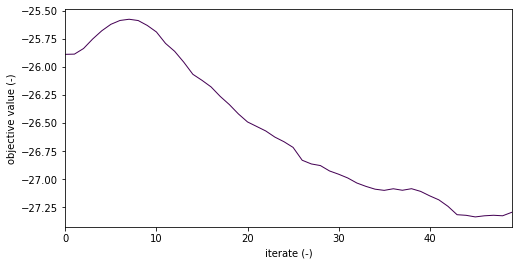

In [87]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
colours = get_cmap("viridis")(np.linspace(0,0.9,4))                    
ax.plot(adam.fh,c=colours[0],lw=1)
ax.set_xlabel("iterate (-)")
ax.set_ylabel("objective value (-)")
ax.set_xlim(0,len(adam.fh)-1)

Intermediate solutions are stored and can be retrieved from `adam.xh`

(0.0, 19.8)

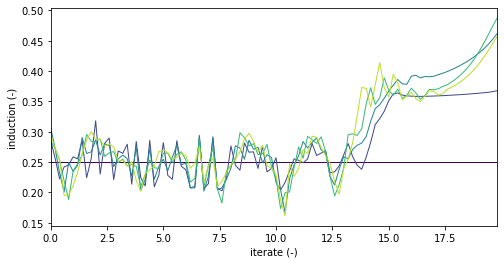

In [86]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
colours = get_cmap("viridis")(np.linspace(0,0.9,5))                    
plot_iterate = np.linspace(0,49,5,dtype=int)
t = np.arange(num_steps_opt)*fvw.time_step
for it in range(5):
    iterate = plot_iterate[it]
    ax.plot(t,adam.xh[iterate],c=colours[it],lw=1)
ax.set_xlabel("iterate (-)")
ax.set_ylabel("induction (-)")
ax.set_xlim(0,t[-1])

Reconstruct power signals for initial guess and for optimisation results

In [77]:
controls_opt[:,fvw.induction_idx] = initial_guess
state_history = fvw.run_forward(initial_condition,
                     controls_opt,
                     inflow_opt,
                     num_steps_opt,
                     with_tangent=False)[0]
power_0 = np.zeros((num_steps_opt, fvw.total_turbines))
for k in range(num_steps_opt):
    power_0[k,:] = fvw.calculate_power(state_history[k],
                   controls_opt[k],
                   with_tangent=False)[0]
    
controls_opt[:,fvw.induction_idx] = x_opt
state_history = fvw.run_forward(initial_condition,
                     controls_opt,
                     inflow_opt,
                     num_steps_opt,
                     with_tangent=False)[0]
power_1 = np.zeros((num_steps_opt, fvw.total_turbines))
for k in range(num_steps_opt):
    power_1[k,:] = fvw.calculate_power(state_history[k],
                   controls_opt[k],
                   with_tangent=False)[0]

Plot result of optimisation: control signal and total power

Text(0.5, 0, 'time (-)')

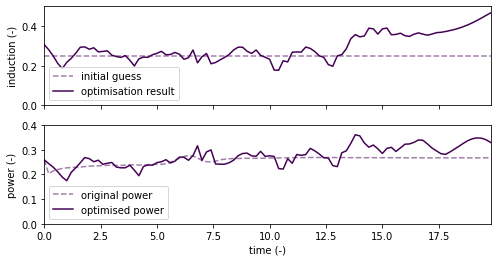

In [88]:
fig,axes = plt.subplots(2,1,figsize=(8,4),sharex='all')
colours = get_cmap("viridis")(np.linspace(0,0.9,4))      
t = np.arange(num_steps_opt)*fvw.time_step
ax = axes[0]
ax.plot(t,initial_guess,label="initial guess",ls='--',alpha=0.5,c=colours[0])
ax.plot(t,x_opt,label="optimisation result",c=colours[0])
ax.legend(loc=3)
ax.set_xlim(0,t[-1])
ax.set_ylim(0,0.5)
ax.set_ylabel("induction (-)")

ax = axes[1]
ax.plot(t,power_0.sum(axis=1),c=colours[0],ls='--',alpha=0.5,label="original power")
ax.plot(t,power_1.sum(axis=1),c=colours[0],label="optimised power")
ax.legend(loc=3)
ax.set_ylim(0,.4)
ax.set_ylabel("power (-)")
ax.set_xlabel("time (-)")